In [ ]:
# Connecting to Google Colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Installing the required libraries
!pip install sentencepiece optuna
!pip install transformers datasets
!pip install torch huggingface_hub 
!pip install rouge.score nltk py7zr
!pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 22.3 MB/s eta 0:00:0

In [ ]:
# Importing the necessary libraries
import torch
import numpy as np
import pandas as pd
import datasets
import transformers
import nltk
import optuna
import os
from collections import defaultdict
from scipy.spatial.distance import cosine

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
!apt-get update -qq && apt-get install -y -qq locales
!locale-gen en_US.UTF-8
!update-locale LANG=en_US.UTF-8
!export LC_ALL=en_US.UTF-8
!export LANG=en_US.UTF-8
!pip install --no-cache-dir https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.1.0/en_core_web_sm-3.1.0.tar.gz
import spacy

# Load pre-trained word embeddings
nlp = spacy.load("en_core_web_sm")


Generating locales (this might take a while)...
  en_US.UTF-8... done
Generation complete.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 137.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 659.5/659.5 kB 195.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 153.8 MB/s eta 0:00:00
  Created wheel for en-core-web-sm: filename=en_core_web_sm-3.1.0-py3-none-any.whl size=13622652 sha256=fb0d9573f3d724342932d53475a9139a81c2f0d7a61721d325a4ec4d066b5b2d
  Stored in directory: /tmp/pip-ephem-wheel-cache-bsmhr34v/wheels/7d/6e/48/3d557772e2dba160f9e80683da52497090100cde2173ef5e34
Successfully built en-core-web-sm
  Attempting uninstall: wasabi
    Found existing installation: wasabi 1.1.1
    Uninstalling wasabi-1.1.1:
      Succ

In [ ]:
# Function to extract aspect sentences
def extract_aspect_sentences(document, aspects, threshold=0.2):
    aspect_sentences = defaultdict(list)
    aspect_sentences_combined = []

    doc = nlp(document)

    for sent in doc.sents:
        for aspect_name, aspect in aspects.items():
            if isinstance(aspect, str):
                for ent in sent.ents:
                    if ent.label_.lower() == aspect:
                        aspect_sentences[aspect_name].append(sent.text)
            else:
                sent_embedding = nlp(sent.text).vector
                similarity = 1 - cosine(aspect, sent_embedding)
                if similarity > threshold:
                    aspect_sentences[aspect_name].append(sent.text)

    for aspect_name in aspects.keys():
        if aspect_sentences[aspect_name]:
            aspect_sentences_combined.append(" ".join(aspect_sentences[aspect_name]))
        else:
            aspect_sentences_combined.append(f"No information found related to the aspect '{aspect_name}' in the document.")

    return " ".join(aspect_sentences_combined)

# Define the aspects you're interested in

military_weapons_aspect = nlp("military weapons").vector
humanitarian_impact_aspect = nlp("humanitarian impact").vector
criminal_activity_aspect = nlp("criminal activity").vector
legal_framework_aspect = nlp("legal framework").vector


aspect_mapping = {
    "location": "gpe",
    "person": "person",
    "date": "date",
    "organization": "org",

    "humanitarian_impact": humanitarian_impact_aspect,
    "criminal_activity": criminal_activity_aspect,
    "legal_framework": legal_framework_aspect,
    "military weapons" : military_weapons_aspect
}


In [ ]:
# Create function for printing 
def print_custom(text):
    print('\n')
    print(text)
    print('-'*100)

# Specify our parameter and project variables
# These parameter range can be changed with respect to amount of processing power available (GPU)
LR_MIN = 3e-5
LR_CEIL = 0.01
WD_MIN = 2e-5
WD_CEIL = 0.01
MIN_EPOCHS = 7
MAX_EPOCHS = 15
MIN_BATCH_SIZE = 4
MAX_BATCH_SIZE = 6
NUM_TRIALS = 1
WARMUP_RATIO_MIN = 0.05
WARMUP_RATIO_MAX = 0.1
SAVE_DIR = 'opt-test'
ASPECT_MODEL_NAME = 't5-small'
MAX_INPUT = 512
MAX_TARGET = 250

# Selecting the first 2000 rows just to see if the GPU issue doesnt recreate as the dataset is large
dataset_path = 'gdrive/My Drive/fyp/'
data = pd.read_csv(dataset_path + 'xsum.csv', encoding='latin-1')
data = data[0:2000]

metric = datasets.load_metric('rouge')
data

<ipython-input-8-5b51af48b15a>:30: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = datasets.load_metric('rouge')


,document,summary
0,"The full cost of damage in Newton Stewart, one...",Clean-up operations are continuing across the ...
1,A fire alarm went off at the Holiday Inn in Ho...,Two tourist buses have been destroyed by fire ...
2,Ferrari appeared in a position to challenge un...,Lewis Hamilton stormed to pole position at the...
3,"John Edward Bates, formerly of Spalding, Linco...",A former Lincolnshire Police officer carried o...
4,Patients and staff were evacuated from Cerahpa...,An armed man who locked himself into a room at...
...,...,...
1995,The former Aberconwy assembly member beat inde...,Conwy council has elected Plaid Cymru's Gareth...
1996,Variety says it will be based on the Iron Man ...,Robert Downey Jr is in talks to team up with T...
1997,I've always been suspicious of this sort of me...,Quite often management books look to the symph...
1998,The Scottish Fire and Rescue Service said more...,Firefighters battling the blaze at Glasgow Sch...


In [ ]:
# Loading tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(ASPECT_MODEL_NAME)

In [ ]:
# Preprocessing the data
prefix = "summarize: "
def preprocess_data(data_to_process):
    #get the document text
    
    inputs = [prefix + doc for doc in data_to_process["document"]]
  
    #tokenize text
    model_inputs = tokenizer(inputs,  max_length=MAX_INPUT, padding='max_length', truncation=True)

    #tokenize labels
    with tokenizer.as_target_tokenizer():
        targets = tokenizer(data_to_process['summary'], max_length=MAX_TARGET, padding='max_length', truncation=True)
        
    model_inputs['labels'] = targets['input_ids']
    return model_inputs

In [ ]:
#  Perform a train test split of 80:20 ratio on the dataset
train_dataset = data[:int(len(data)*0.7)]
test_dataset = data[int(len(data)*0.7):int(len(data)*0.85)]
validation_dataset = data[int(len(data)*0.85):]

# Creating the dataset dictionary
data = datasets.DatasetDict({ 'train': datasets.Dataset.from_pandas(train_dataset), 
                              'test': datasets.Dataset.from_pandas(test_dataset),
                              'validation': datasets.Dataset.from_pandas(train_dataset)})

In [ ]:
# Preprocess the data
tokenize_data = data.map(preprocess_data, batched = True, remove_columns=['document', 'summary'])

Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

In [ ]:
#sample the data
train_sample = tokenize_data['train'].shuffle(seed=123).select(range(1000))
validation_sample = tokenize_data['validation'].shuffle(seed=123).select(range(300))
test_sample = tokenize_data['test'].shuffle(seed=123).select(range(200))
     
# Update the tokenize_data dictionary
tokenize_data['train'] = train_sample
tokenize_data['validation'] = validation_sample
tokenize_data['test'] = test_sample

tokenize_data

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 200
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 300
    })
})

In [ ]:
#load model
model = transformers.AutoModelForSeq2SeqLM.from_pretrained(ASPECT_MODEL_NAME)

# We are using batch_size to handle with the GPU limitation but if GPU size is not a limitation please use the recommend batch size from the hyperparameters
batch_size = 1

#data_collator to create batches. It preprocess data with the given tokenizer
data_collator = transformers.DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:

# metrics
# compute rouge for evaluation 

def compute_rouge(pred):
    predictions, labels = pred
    #decode the predictions
    decode_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    #decode labels
    decode_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    #compute results
    res = metric.compute(predictions=decode_predictions, references=decode_labels, use_stemmer=True)
    res = {key: value.mid.fmeasure * 100 for key, value in res.items()}

    #compute the average of the rouge scores
    pred_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    res['gen_len'] = np.mean(pred_lens)

    return {k: round(v, 4) for k, v in res.items()}


In [ ]:
# Create the training arguments
args = transformers.Seq2SeqTrainingArguments(
    'aspect-based-summary',
    evaluation_strategy='epoch',
    learning_rate=0.001,
    per_device_train_batch_size=1, # this is due to GPU limitation else per_device_train_batch_size should be used 
    per_device_eval_batch_size= 1, # this is due to GPU limitation else per_device_eval_batch_size should be used
    gradient_accumulation_steps=2,
    weight_decay=0.1,
    save_total_limit=2,
    warmup_ratio=0.1,
    num_train_epochs=9,
    predict_with_generate=True,
    eval_accumulation_steps=1,
    fp16=True
  )
#only CUDA available -> fp16=True

# Create the trainer
trainer = transformers.Seq2SeqTrainer(
    model, 
    args,
    train_dataset=tokenize_data['train'],
    eval_dataset=tokenize_data['validation'],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_rouge
)


In [ ]:
# Clearing the cuda memory
import torch
torch.cuda.empty_cache()

In [ ]:

# Train the model
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,1.369700,0.292683,27.728800,7.960400,22.503600,22.473000,18.726700
2,0.343400,0.224625,28.873200,8.988300,23.356900,23.340100,18.810000
3,0.274800,0.163171,34.696500,15.444000,29.240100,29.250000,18.626700
4,0.217800,0.116486,39.443600,21.109000,34.316100,34.263900,18.770000
5,0.171100,0.078957,45.073800,28.469900,40.377200,40.288600,18.756700
6,0.129900,0.049882,53.462200,40.421900,50.200000,50.116200,18.726700
7,0.097200,0.032154,60.780300,51.117600,58.595300,58.569500,18.806700
8,0.074600,0.021784,65.733600,58.115800,63.848000,63.791800,18.760000
9,0.059900,0.017955,69.095200,62.625900,67.692400,67.566400,18.790000


TrainOutput(global_step=4500, training_loss=0.3042493684556749, metrics={'train_runtime': 1276.6781, 'train_samples_per_second': 7.05, 'train_steps_per_second': 3.525, 'total_flos': 1218076213248000.0, 'train_loss': 0.3042493684556749, 'epoch': 9.0})

In [ ]:
# Clearing the cuda memory
torch.cuda.empty_cache()

In [ ]:
# Evaluate the model
metrics = trainer.evaluate()



Printing the metrics
----------------------------------------------------------------------------------------------------
{'eval_loss': 0.017954867333173752, 'eval_rouge1': 69.0952, 'eval_rouge2': 62.6259, 'eval_rougeL': 67.6924, 'eval_rougeLsum': 67.5664, 'eval_gen_len': 18.79, 'eval_runtime': 61.6657, 'eval_samples_per_second': 4.865, 'eval_steps_per_second': 4.865, 'epoch': 9.0}


Creating a line graph for the metrics
----------------------------------------------------------------------------------------------------


<Axes: xlabel='epoch'>

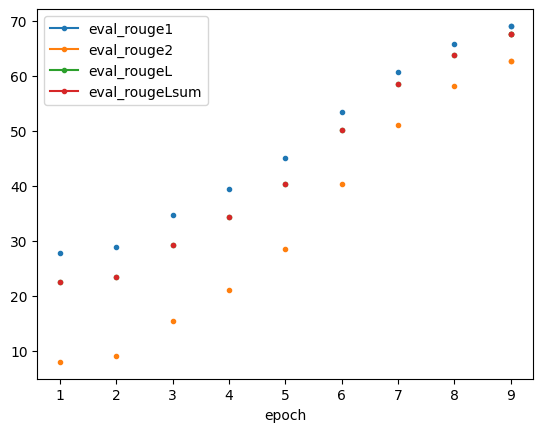

In [ ]:
# Print the metrics
print_custom('Printing the metrics')
print(metrics)

df = pd.DataFrame(trainer.state.log_history)

# Creating a line graph for the metrics
print_custom('Creating a line graph for the metrics')
df.plot(x='epoch', y=['eval_rouge1', 'eval_rouge2', 'eval_rougeL', 'eval_rougeLsum'], style='.-')



Creating the validation loss graph
----------------------------------------------------------------------------------------------------


<Axes: xlabel='epoch'>

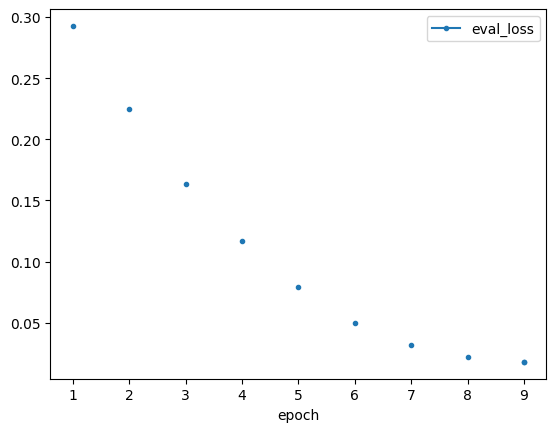

In [ ]:
# Creating the validation loss graph 
print_custom('Creating the validation loss graph')
df.plot(x='epoch', y=['eval_loss'], style='.-')

In [ ]:
import os

import os

def aspect_based_summarization(document, aspect_name):
    aspect_sentences = extract_aspect_sentences(document, {aspect_name: aspect_mapping[aspect_name]})

    if f"No information found related to the aspect '{aspect_name}'" in aspect_sentences:
        return aspect_sentences

    aspect_inputs = tokenizer.encode(aspect_sentences, return_tensors='pt', max_length=MAX_INPUT, truncation=True)



    aspect_outputs = model.generate(aspect_inputs, max_length=450, min_length=50, length_penalty=1.5, num_beams=4, early_stopping=True)
    aspect_based_summary = tokenizer.decode(aspect_outputs[0], skip_special_tokens=True)
    return aspect_based_summary


document = """ The UK is among a number of countries with military special forces operating inside Ukraine, according to one of dozens of documents leaked online.

It confirms what has been the subject of quiet speculation for over a year.

The leaked files, some marked "top secret", paint a detailed picture of the war in Ukraine, including sensitive details of Ukraine's preparations for a spring counter-offensive.

The US government says it is investigating the source of the leak.

According to the document, dated 23 March, the UK has the largest contingent of special forces in Ukraine (50), followed by fellow Nato states Latvia (17), France (15), the US (14) and the Netherlands (1).

The document does not say where the forces are located or what they are doing.

The numbers of personnel may be small, and will doubtless fluctuate. But special forces are by their very nature highly effective. Their presence in Ukraine is likely to be seized upon by Moscow, which has in recent months argued that it is not just confronting Ukraine, but Nato as well.

Key takeaways from leaked Pentagon documents
How secret files appeared online, then began to vanish
In line with its standard policy on such matters, the UK's Ministry of Defence has not commented, but in a tweet on Tuesday said the leak of alleged classified information had demonstrated what it called a "serious level of inaccuracy".

"Readers should be cautious about taking at face value allegations that have the potential to spread misinformation," it said.

It did not elaborate or suggest which specific documents it was referring to. However, Pentagon officials are quoted as saying the documents are real.

One document, which detailed the number of casualties suffered in Ukraine on both sides, did appear to have been doctored.

UK special forces are made up of several elite military units with distinct areas of expertise, and are regarded to be among the most capable in the world.

The British government has a policy of not commenting on its special forces, in contrast to other countries including the US.

The UK has been vociferous in its support of Ukraine, and is the second largest donor after the US of military aid to Kyiv.

US Defense Secretary Lloyd Austin said the Department of Justice had opened a criminal investigation and he was determined to find the source of the leak.

"We will continue to investigate and turn over every rock until we find the source of this and the extent of it," he said.

"""
# Choose the aspect you want to summarize
aspect = "person"
# Generate the summary for the chosen aspect
aspect_specific_summary = aspect_based_summarization(document, aspect)

print("Aspect-based summary:")

print(aspect_specific_summary)     


Aspect-based summary:
Lloyd Austin said the Department of Justice had opened a criminal investigation and was determined to find the source of the leak. US Defense Secretary Lloyd Austin said the Department of Justice had opened a criminal investigation and was determined to find the source of the leak.


In [ ]:
# Save the model
drive_path_to_save_model = 'gdrive/My Drive/fyp/AspectSummarizationModels/' + ASPECT_MODEL_NAME + '-aspect-model'

# Ensure the model directory exists, and create it if not
model_directory = os.path.dirname(drive_path_to_save_model)
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

# Save the model
model.save_pretrained(drive_path_to_save_model)

# Save the tokenizer
drive_path_to_save_tokenizer = 'gdrive/My Drive/fyp/AspectSummarizationModels/' + ASPECT_MODEL_NAME + '-aspect-tokenizer'

# Ensure the tokenizer directory exists, and create it if not
tokenizer_directory = os.path.dirname(drive_path_to_save_tokenizer)
if not os.path.exists(tokenizer_directory):
    os.makedirs(tokenizer_directory)

# Save the tokenizer
tokenizer.save_pretrained(drive_path_to_save_tokenizer)

# Load the model
drive_path_to_load_model = 'gdrive/My Drive/fyp/AspectSummarizationModels/' + ASPECT_MODEL_NAME + '-aspect-model'
loaded_model = transformers.AutoModelForSeq2SeqLM.from_pretrained(drive_path_to_load_model)

# Load the tokenizer
drive_path_to_load_tokenizer = 'gdrive/My Drive/fyp/AspectSummarizationModels/' + ASPECT_MODEL_NAME + '-aspect-tokenizer'
loaded_tokenizer = transformers.AutoTokenizer.from_pretrained(drive_path_to_load_tokenizer)